In [1]:
import torch
import torchvision

from score_models.models.unet.unet import UNet
from score_models.sampling import annealed_langevin_dynamics
from score_models.utils.noise import get_sigmas
from score_models.utils.visualisations import show_torch_images
from score_models.utils.visualisations import tensors_to_gif

In [2]:
L=10
in_ch = 3
ch = 128
ch_mult = [1, 2, 3, 4]
attn = [2]
num_res_blocks = 2
dropout = 0.15
device = "cuda"
compile = False

# construct score model
score_model = UNet(
    T=L, 
    in_ch=in_ch, 
    ch=ch, 
    ch_mult=ch_mult, 
    attn=attn, 
    num_res_blocks=num_res_blocks, 
    dropout=dropout,
).to(device)

# compile model
if compile:
    score_model = torch.compile(score_model)

# load pre-trained model
path = "../scripts/checkpoints/ncsn_cifar10/200000.pt"
score_model.load_state_dict(
    torch.load(path)["model_state_dict"]
)

# define train step (i.e., criterion)
sigma_min, sigma_max = 0.01, 1.0
sigmas = get_sigmas(L=L, sigma_min=sigma_min, sigma_max=sigma_max)

In [3]:
history_buffer = []
x = torch.rand(32, 3, 32, 32).to(device)
samples = annealed_langevin_dynamics(
    x=x,
    score_model=score_model, 
    sigmas=sigmas,
    T=100,
    eps=2e-5,
    history_buffer=history_buffer,
).cpu()
samples = torch.clamp(samples, 0, 1)

100%|██████████| 1000/1000 [00:49<00:00, 20.04it/s]


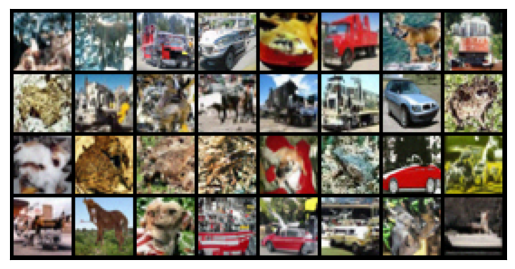

In [4]:
grid = torchvision.utils.make_grid(samples, nrow=8, normalize=True, value_range=(0, 1))
show_torch_images(grid)

In [5]:
# save to gif
subsampled_history_buffer = [history_buffer[i] for i in range(0, len(history_buffer), 10)]
tensors_to_gif(subsampled_history_buffer, "../imgs/ncsn-sampling.gif", duration=2., value_range=(0, 1))